In [2]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
# Define the damped sine wave function
def damped_sine_wave(t, A, omega, phi, alpha):
    return A * np.exp(-alpha * t) * np.sin(omega * t + phi)

def damped_sine_wave_2(t, A1, omega1, phi1, alpha1, A2, omega2, phi2, alpha2):
    return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)

In [14]:
# Get time history data from Velociraptor3D

data = []
current_group = []
with open('Data\\rising_truss_Data.txt') as f:
    for line in f:
        if line.strip():  # If the line is not empty
            row = [float(x) for x in line.split()]
            current_group.append(row)
        else:  # If the line is empty
            if current_group:
                data.append(current_group)
                current_group = []
data = np.array(data)
print(data.shape)

(1, 32, 200)


In [15]:
#Dataprep:

print(data.shape)
dt = 0.01
T = 2
time = np.arange(0,T,dt)

dataY = []
dataY = np.zeros((len(data),32,8))

for bridge_ind in range(0, data.shape[0]):
    for node_ind in range(0, data.shape[1]):
        try:
            #Time history for node nr. node_ind in bridge nr. bridge_ind
            node_disp = data[bridge_ind][node_ind]
            #Initial guess for optimized parameters
            A = (np.max(node_disp) - np.min(node_disp)) / 2
            if (A==0):
                continue    
            else:
                initial_guess = [A, 1, 1, 1]
                #Optimized parameters for simple sine wave
                optimized_parameters, _ = curve_fit(damped_sine_wave, time, node_disp, p0=initial_guess, maxfev=1000)
                #Fitted graph nr. 1
                g1 = damped_sine_wave(time, *optimized_parameters)
                #Error between actual time history and fitted graph
                error = node_disp - g1
                #Optimized parameters for the error graph
                optimized_parameters_2, _ = curve_fit(damped_sine_wave, time, error, p0=initial_guess)
                #Initital guess for the double sine wave function are the 8 optimized parameters from above
                initial_guess_2 = (*optimized_parameters, *optimized_parameters_2)
                #Finished fitted graph
                try: #try to fit a better graph
                    optimized_parameters_3, _ = curve_fit(damped_sine_wave_2, time, node_disp, p0=initial_guess_2)
                except: #return the first fitted graph if it doesn't work
                    optimized_parameters_3 = [*optimized_parameters,0,0,0,0]
                #Set the 8 optimized parameters as replacement to the 2000 displacements 
                #at the right spot of the label matrix dataY
                dataY[bridge_ind][node_ind] = [*optimized_parameters_3]
        except:
            continue




(1, 32, 200)


In [16]:
print(dataY.shape)

(1, 32, 8)


In [17]:
points_data = np.loadtxt("Data\\rising_truss_Points.txt")
dataX = np.zeros((dataY.shape[0], 32, 4))
bridge_ind = 0
for row_ind in range(0, points_data.shape[0], 3):
    for node_ind in range(0, points_data.shape[1]):
        dataX[bridge_ind][node_ind] = \
        [node_ind, 
         points_data[row_ind][node_ind],
         points_data[row_ind + 1][node_ind],
         points_data[row_ind + 2][node_ind]]
    bridge_ind += 1
print(dataX.shape)

(1, 32, 4)


In [18]:
edge_index_data = np.loadtxt("Data\\rising_truss_EdgeIndex.txt")
dataEdgeIndex = edge_index_data.T
print(dataEdgeIndex.shape)

(2, 128)


In [11]:
#Create dataset with PyTorch Data objects
data_set = []
for i in range(0, dataY.shape[0]):
    data_set.append(Data(x = torch.from_numpy(dataX[i]).float(), 
                         edge_index = torch.from_numpy(dataEdgeIndex).long(),
                         y = torch.from_numpy(dataY[i]).float(),
                         bridge_id = i))
print(data_set[0])
#shuffle and save data
from random import shuffle
shuffle(data_set)
print(data_set[0])
torch.save(data_set, "Data\\rising_truss_DataObjects")


Data(x=[32, 4], edge_index=[2, 128], y=[32, 8], bridge_id=0)
Data(x=[32, 4], edge_index=[2, 128], y=[32, 8], bridge_id=0)


In [12]:
print(data_set[0].x)

tensor([[0.0000e+00, 0.0000e+00, 5.0000e+03, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.6000e+03, 5.0000e+03, 0.0000e+00],
        [3.0000e+00, 2.6000e+03, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 5.2000e+03, 5.0000e+03, 0.0000e+00],
        [5.0000e+00, 5.2000e+03, 0.0000e+00, 0.0000e+00],
        [6.0000e+00, 7.8000e+03, 5.0000e+03, 0.0000e+00],
        [7.0000e+00, 7.8000e+03, 0.0000e+00, 0.0000e+00],
        [8.0000e+00, 1.0400e+04, 5.0000e+03, 0.0000e+00],
        [9.0000e+00, 1.0400e+04, 0.0000e+00, 0.0000e+00],
        [1.0000e+01, 1.3000e+04, 5.0000e+03, 0.0000e+00],
        [1.1000e+01, 1.3000e+04, 0.0000e+00, 0.0000e+00],
        [1.2000e+01, 1.5600e+04, 5.0000e+03, 0.0000e+00],
        [1.3000e+01, 1.5600e+04, 0.0000e+00, 0.0000e+00],
        [1.4000e+01, 1.8200e+04, 5.0000e+03, 0.0000e+00],
        [1.5000e+01, 1.8200e+04, 0.0000e+00, 0.0000e+00],
        [1.6000e+01, 2.0800e+04, 5.0000e+03, 0.0000e+00],
        [1.700

2.6964424651505245 78.96360892878289 -2.028637136648744 4.0495940761346185 0.8145044407263686 119.94546598691741 -1.994813312706469 11.958323454713605


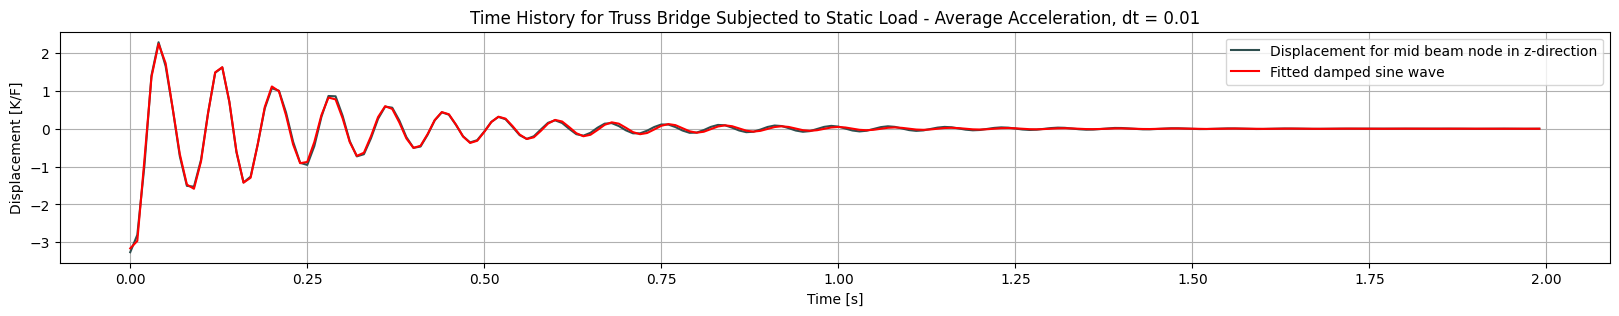

(1, 32, 200)
(1, 32, 8)


In [23]:
# Test

print(*dataY[0][4])

fitted = damped_sine_wave_2(time, *dataY[0][4])

title = 'Time History for Truss Bridge Subjected to Static Load - Average Acceleration, dt = '+str(dt)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.plot(time, data[0][4], color='darkslategrey', label='Displacement for mid beam node in z-direction')
plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [K/F]')
plt.grid()
plt.legend()
plt.title(title)
plt.show()

print(data.shape)
print(dataY.shape)

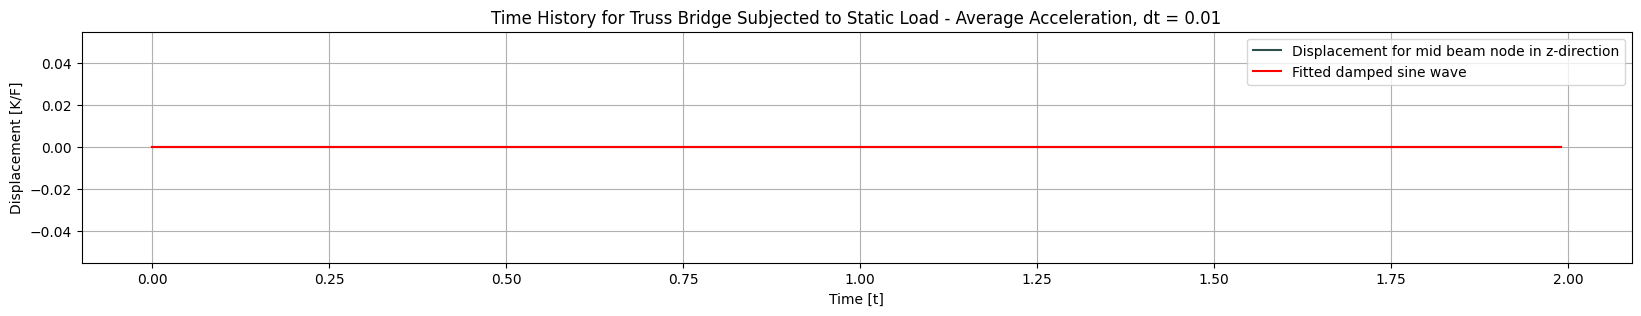

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


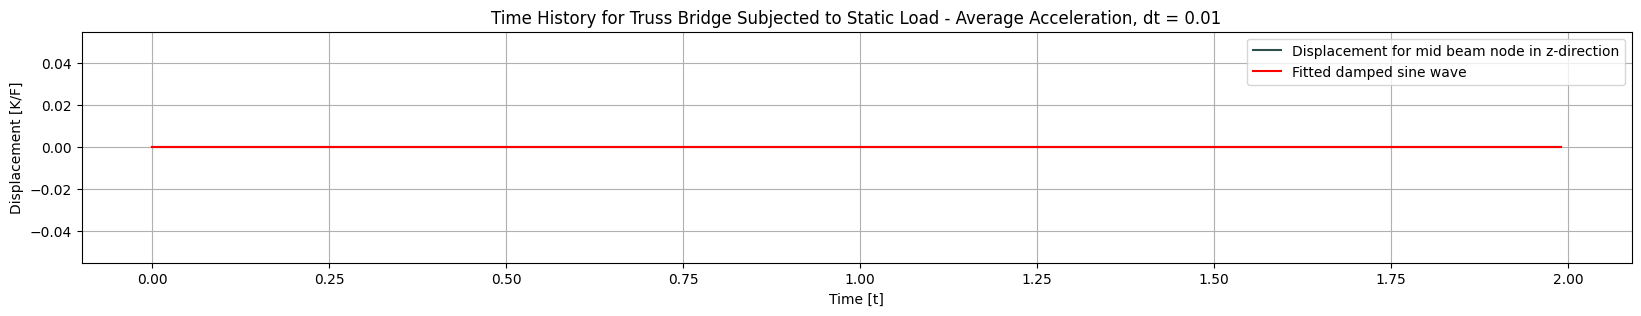

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


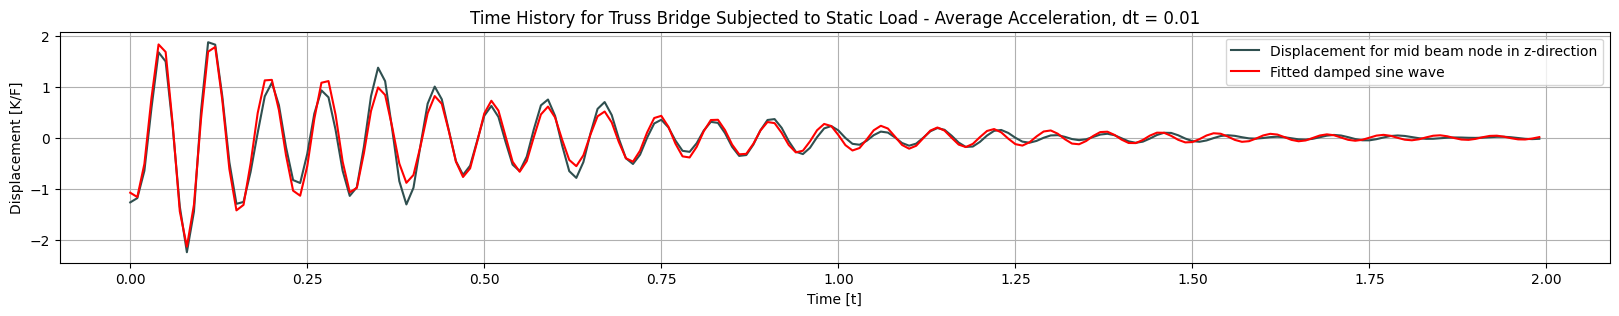

optimized parameters: 
2.0257949253775323 79.86297852766683 -1.5255237517309976 2.0335040523026295 -0.9924260955158498 108.95039995175007 -1.2638106907899664 9.336783755353826


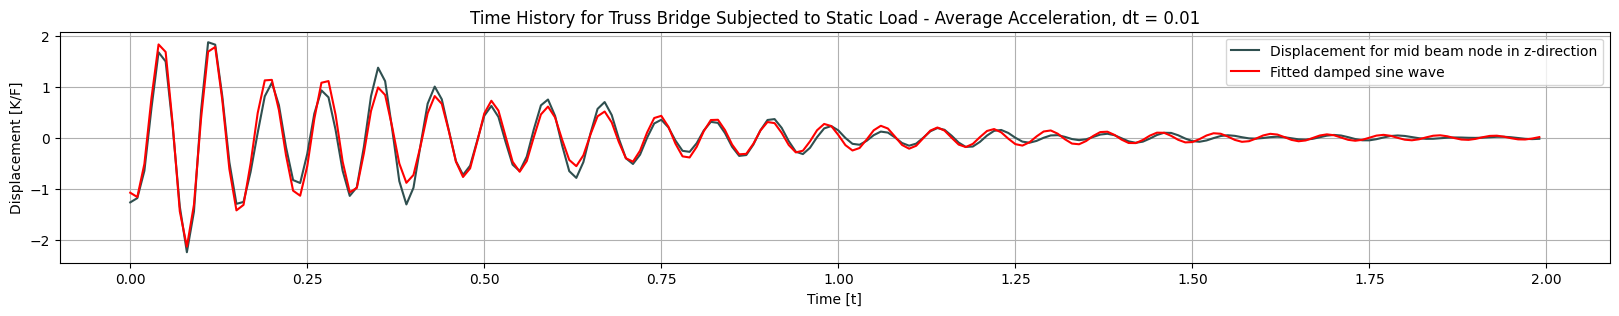

optimized parameters: 
2.0257949264133073 79.86297852700461 -1.5255237515677502 2.033504051260735 -0.9924261031600174 108.95040004938545 -1.2638106909378723 9.336783897232529


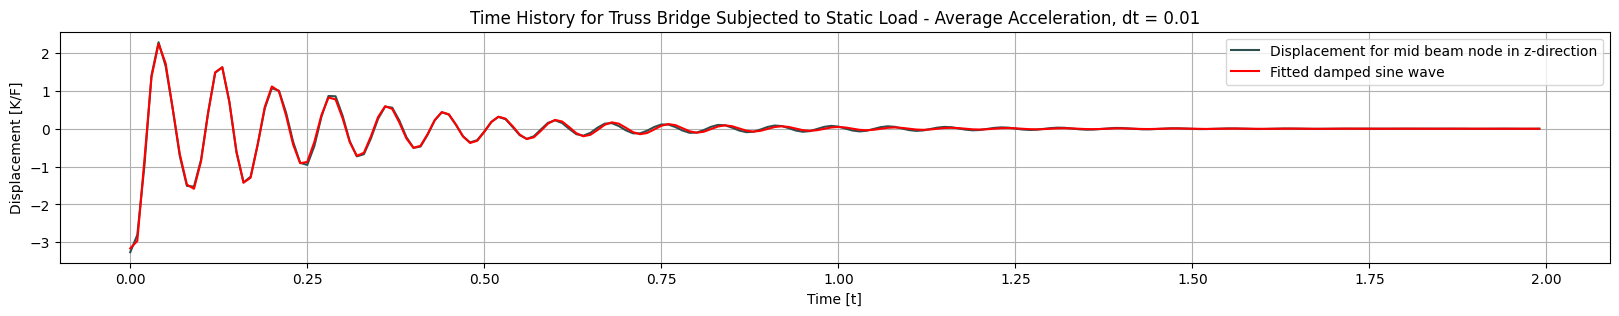

optimized parameters: 
2.6964424651505245 78.96360892878289 -2.028637136648744 4.0495940761346185 0.8145044407263686 119.94546598691741 -1.994813312706469 11.958323454713605


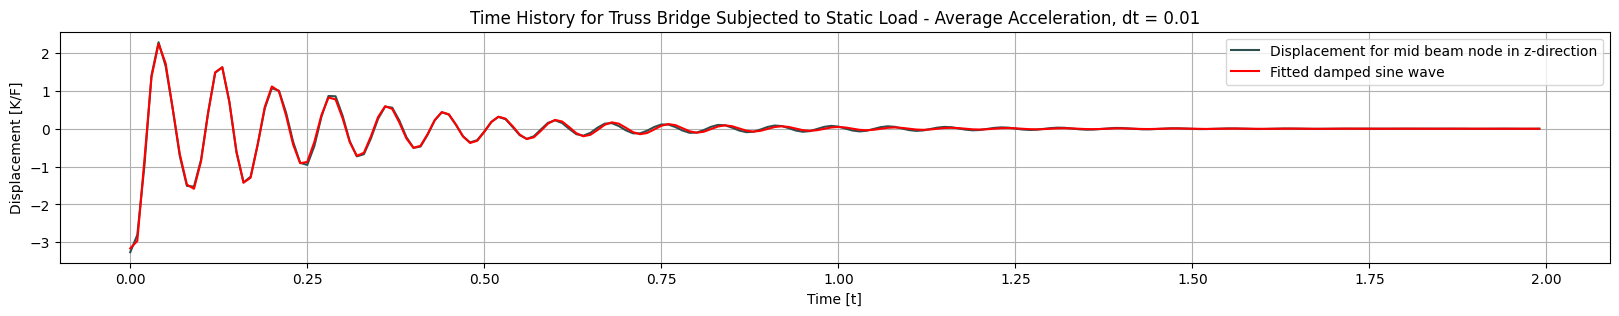

optimized parameters: 
2.6964424674222514 78.96360894564216 -2.028637140819751 4.049594078706089 0.8145044400789032 119.94546586190218 -1.9948133022499575 11.958323321588265


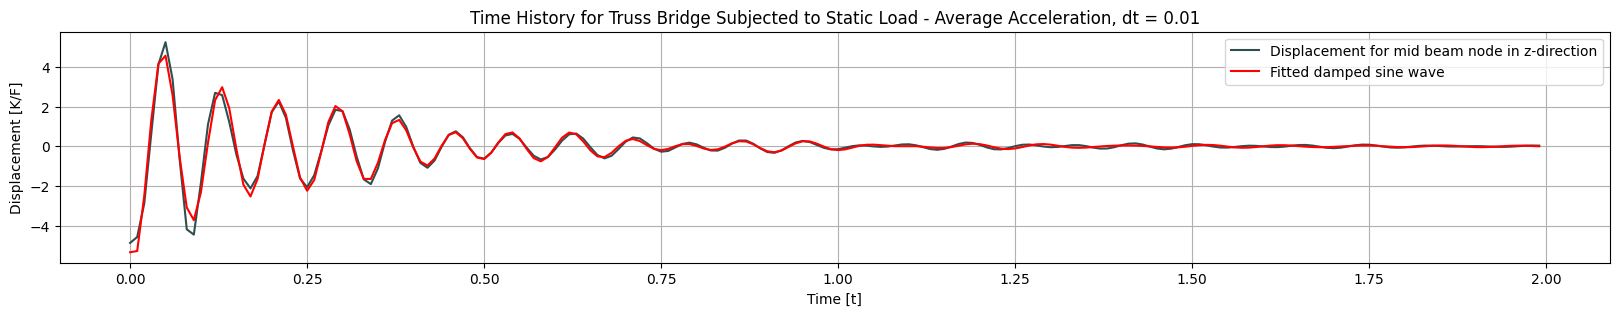

optimized parameters: 
5.385467072754277 76.28384665439276 -1.9720719333259085 3.777351177028671 -0.4188836110421497 56.22023426685389 -5.223645348777612 1.2542805341281447


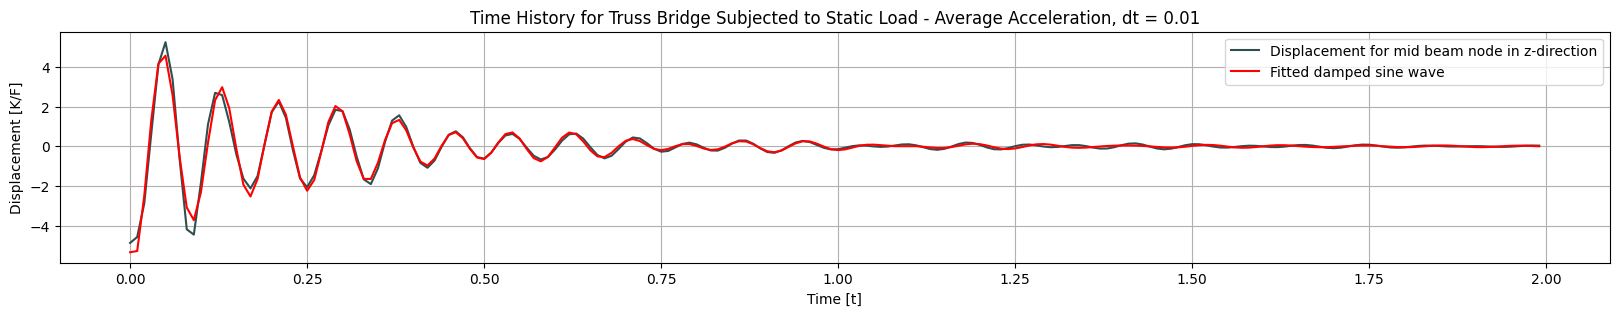

optimized parameters: 
5.385467062597403 76.28384664099259 -1.9720719287294053 3.7773511693757476 -0.41888363877192963 56.22023423739577 -5.22364533708984 1.2542806713374826


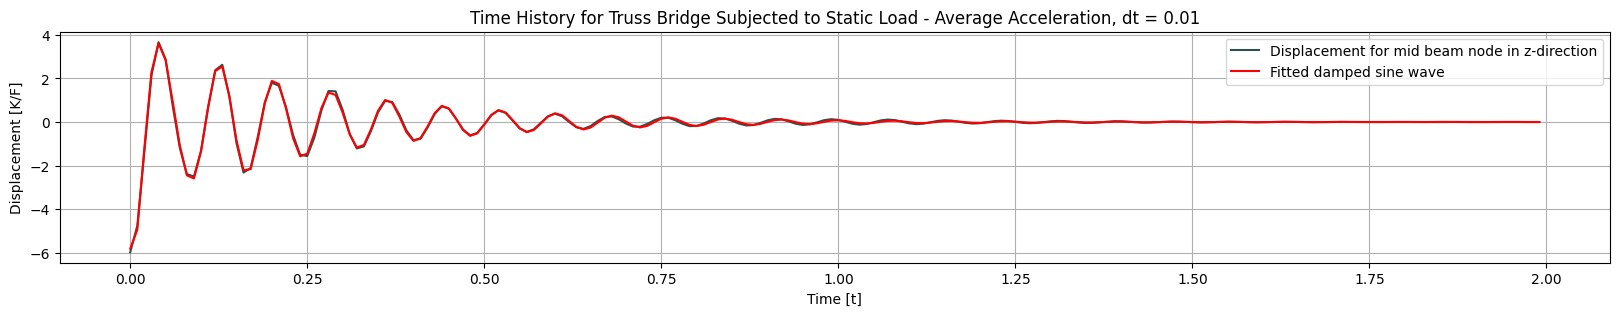

optimized parameters: 
4.398607251275812 79.15737579791626 -2.0773585337715037 3.984104219490301 1.9803514385041827 113.56690057506948 -1.7018049727241387 17.852216814364226


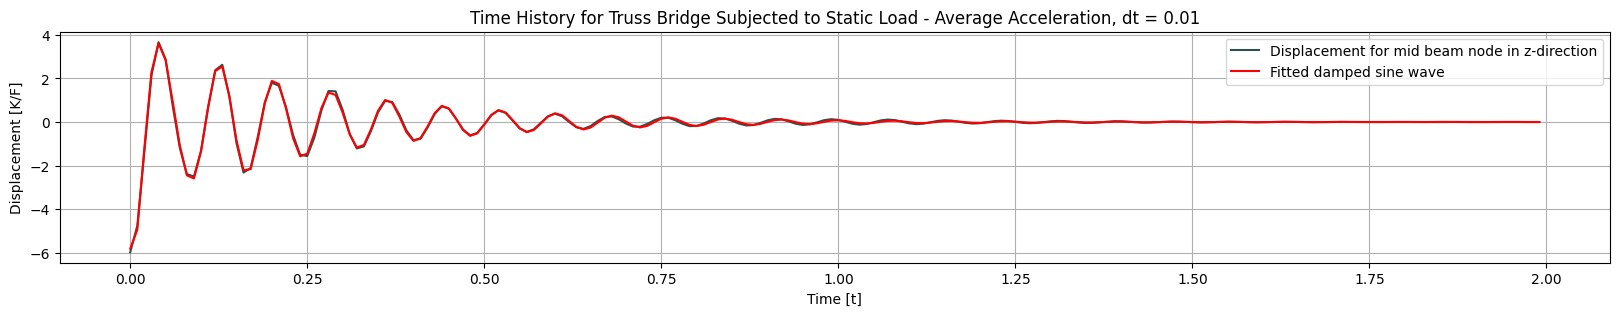

optimized parameters: 
4.3986072496279185 79.15737580606607 -2.077358535931989 3.9841042187209954 1.9803514461882377 113.56690053983127 -1.701804973862035 17.852216840328886


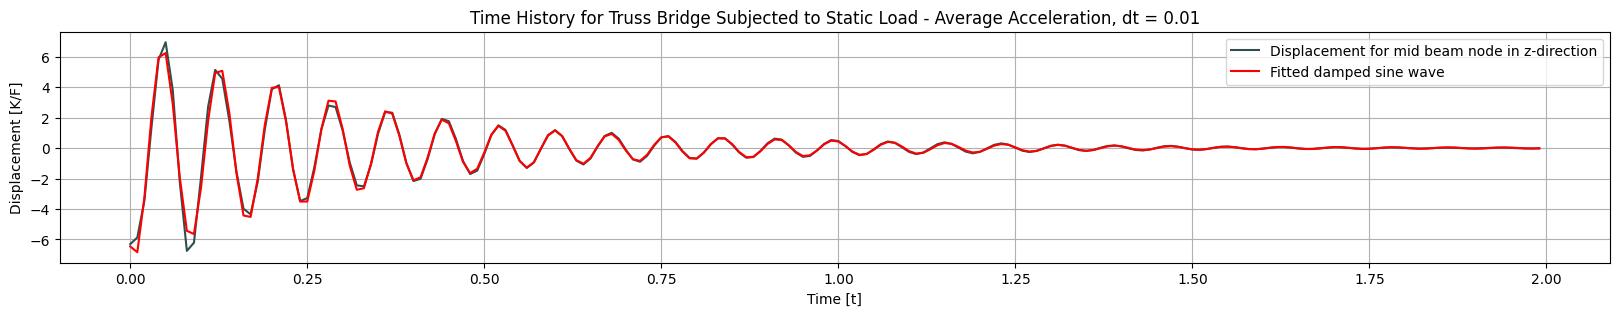

optimized parameters: 
6.577668855929269 79.56427530079455 -2.165037366029761 2.6749066622354607 -1.0422222178322516 73.19482001997821 -4.4644681998412 2.985777755757299


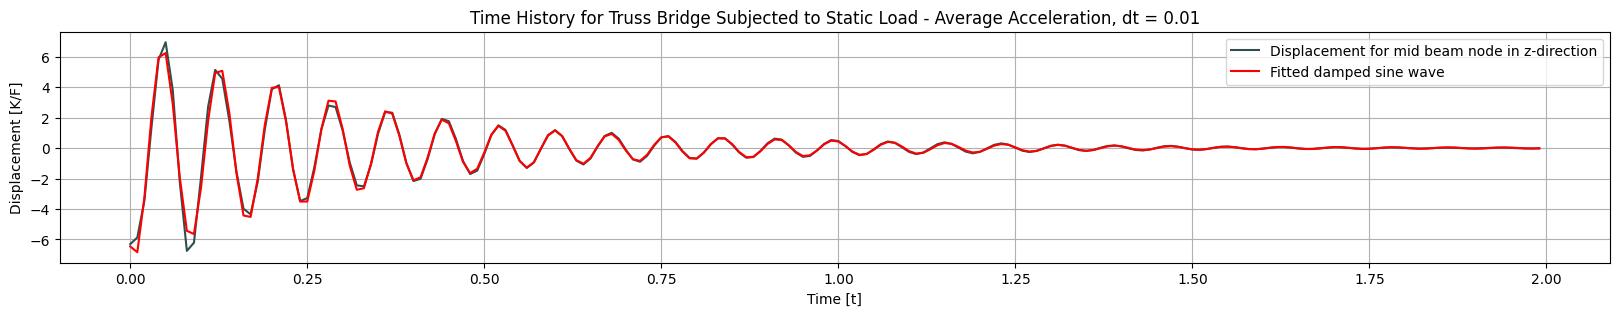

optimized parameters: 
6.577668958257252 79.56427531280288 -2.1650373810099794 2.6749067107453204 -1.0422222003844877 73.19481974717388 -4.464468072574875 2.98577802046276


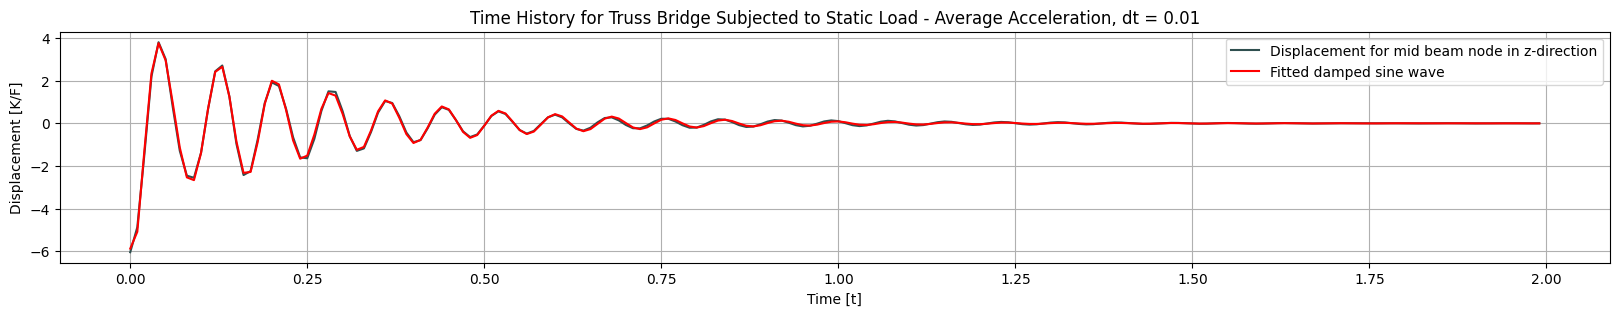

optimized parameters: 
4.548590276089419 79.20805339539348 -2.081717326092537 3.9197880814283863 1.9198927207368879 113.01478347355295 -1.7002265177533522 16.4064490316989


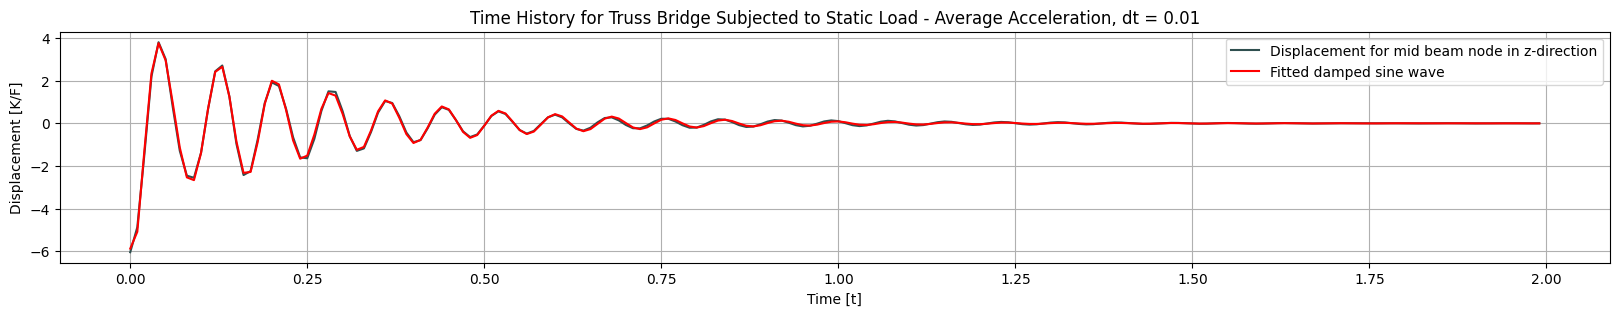

optimized parameters: 
4.548590267085014 79.20805338863862 -2.081717324586927 3.9197880741011075 1.9198927317407544 113.01478359245489 -1.700226525133496 16.406449268793335


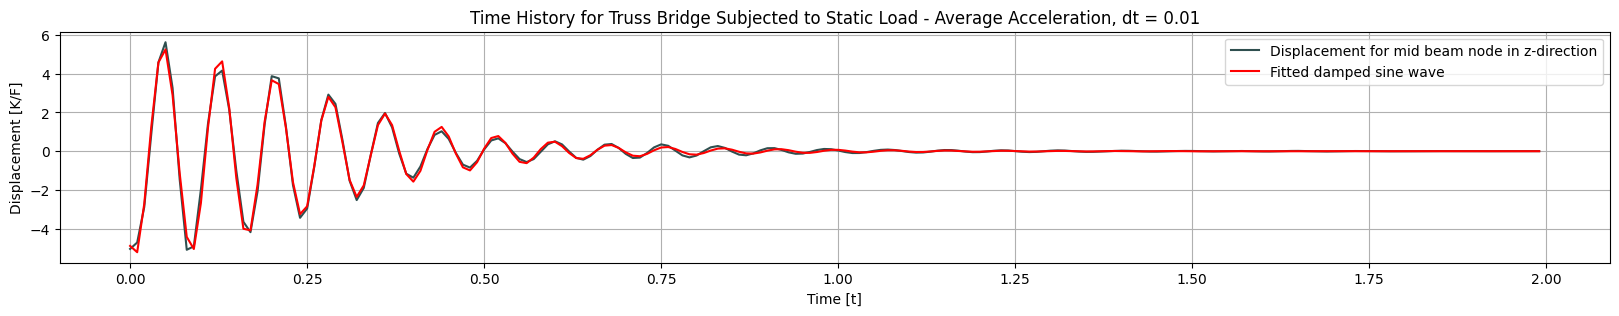

optimized parameters: 
9.399897437383014 79.13541286956978 -1.82785268365055 4.853533044181184 -4.209993865758984 87.00853644854193 -1.562990178463756 7.290730735645556


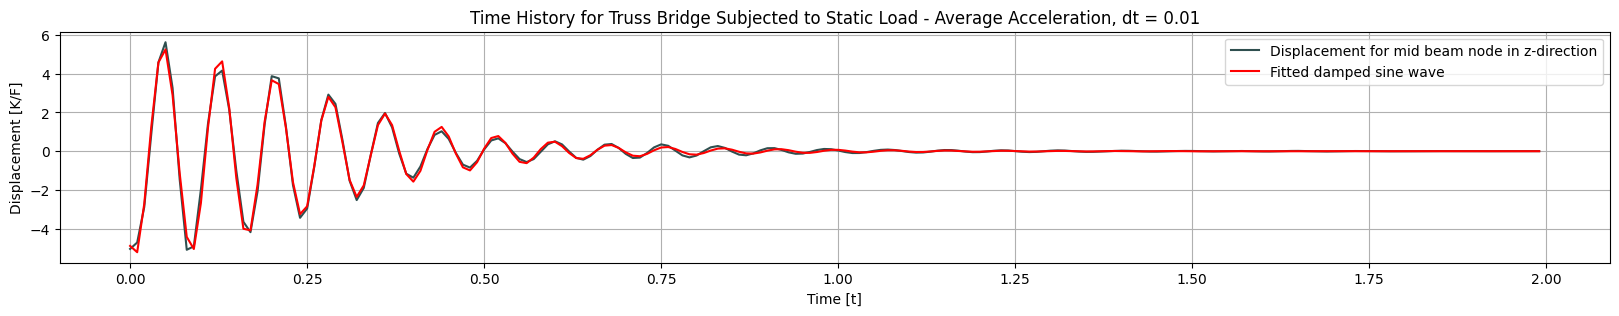

optimized parameters: 
9.39989767170415 79.1354127275292 -1.8278526072328087 4.8535332102550255 -4.209994338948024 87.00853556667892 -1.5629900220580522 7.290730350730536


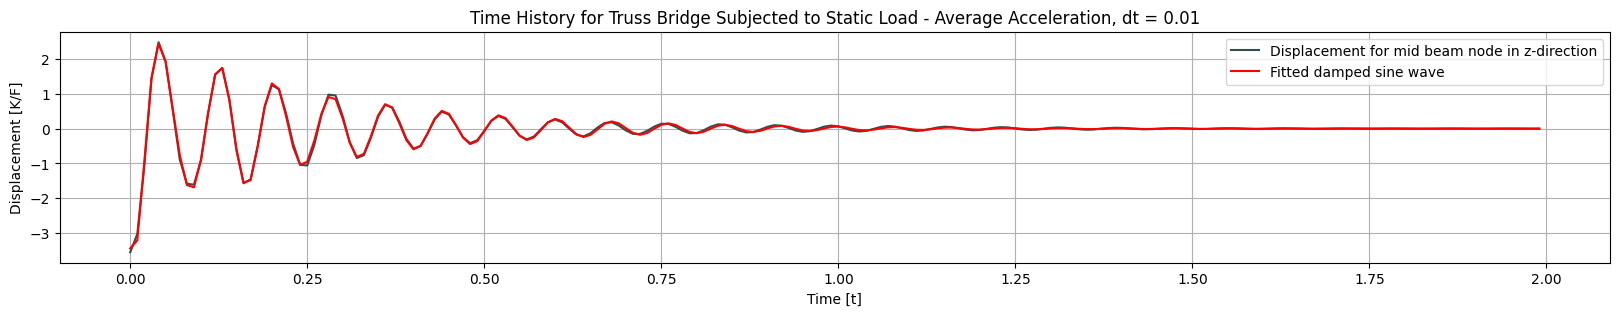

optimized parameters: 
2.9021043425891784 79.14547903664491 -2.056507417201238 3.8800468691784906 0.9202814887190883 116.02870351114284 -1.8946661903781952 12.234635610418579


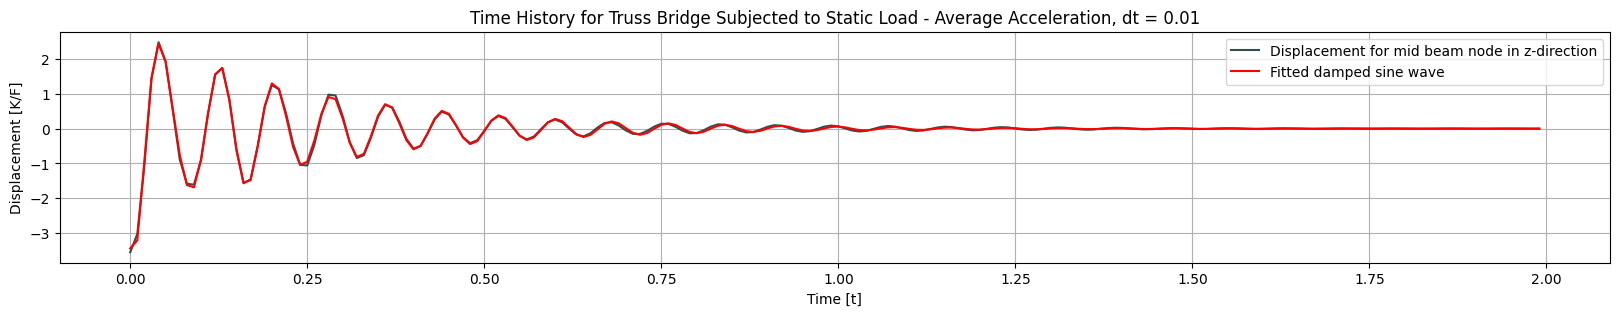

optimized parameters: 
2.9021043421089407 79.14547904173976 -2.0565074184985743 3.8800468684907363 0.9202814936700898 116.02870334488206 -1.8946661817146446 12.23463572373525


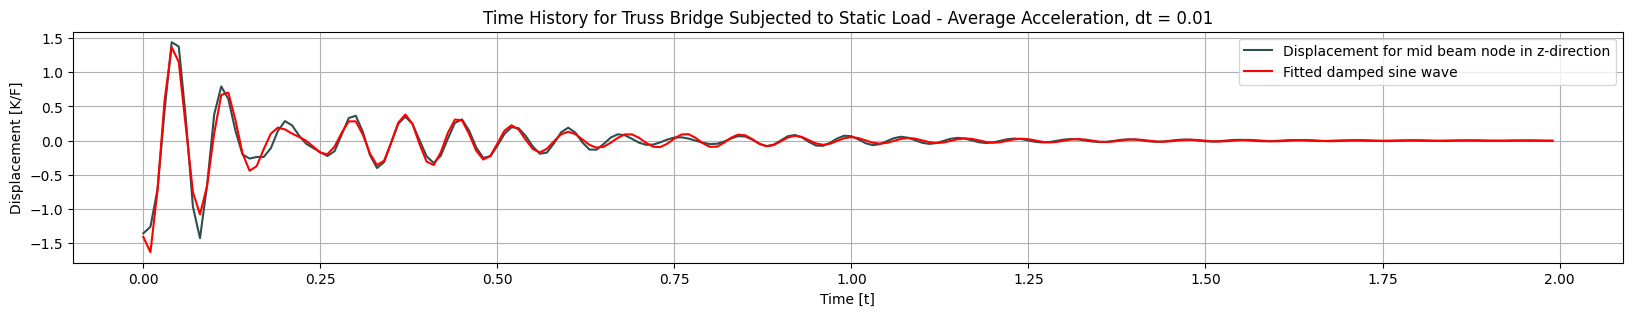

optimized parameters: 
0.7808185931414949 78.99560968851571 -2.1796903801579606 2.6963418737131355 0.9710461106287225 93.37852247093839 -2.2255444333137353 5.205651909140765


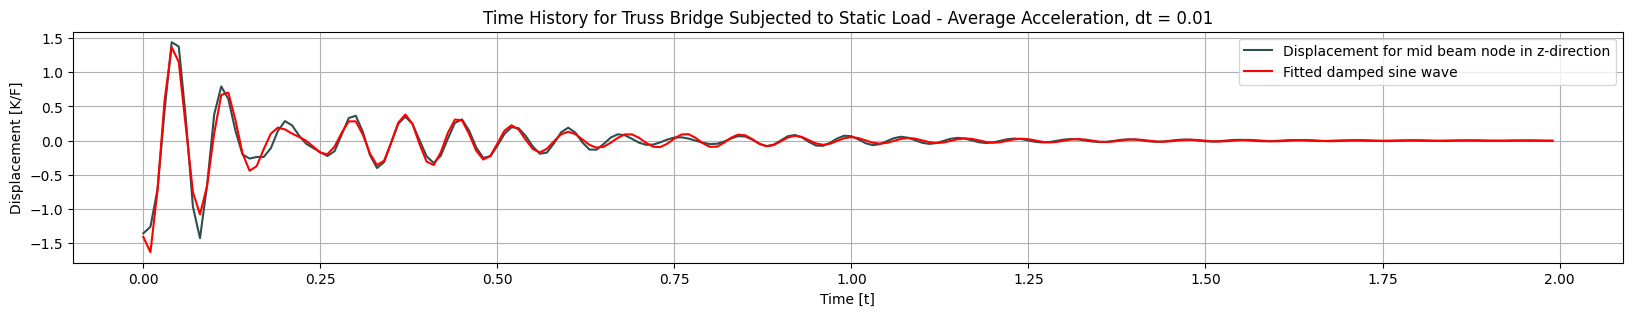

optimized parameters: 
0.7808186224988756 78.99560966747336 -2.1796903539166874 2.6963419846493353 0.9710460575294586 93.37852276224402 -2.2255444544171485 5.205651548439281


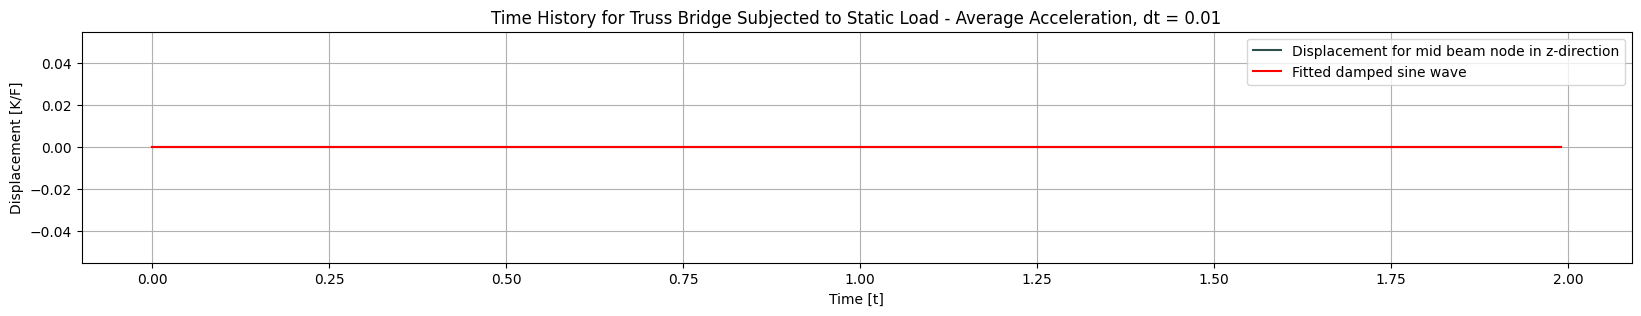

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


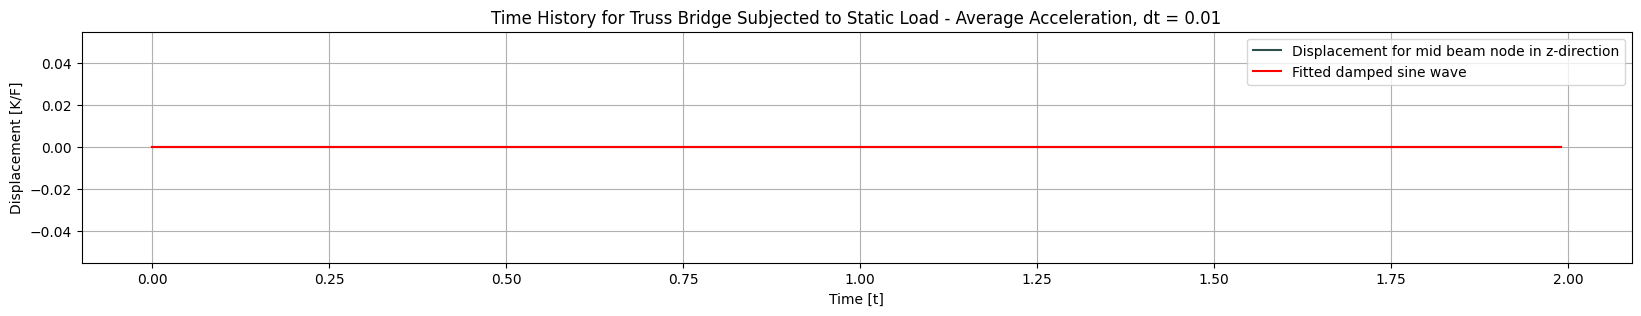

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


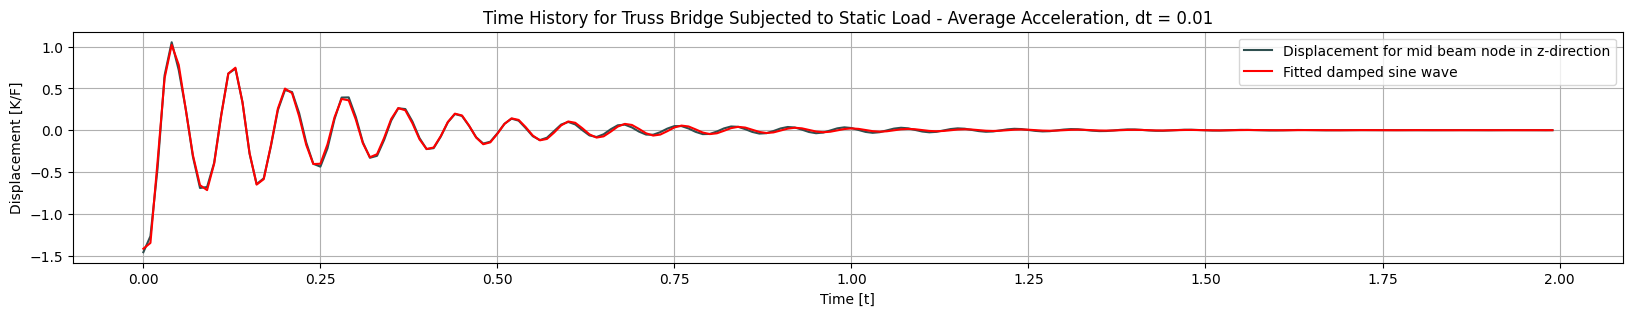

optimized parameters: 
1.2219757176905806 78.88754673253757 -2.024422678011754 4.059479507654668 0.36066169060716585 120.84467030347794 -2.0497058656326166 10.94993902216679


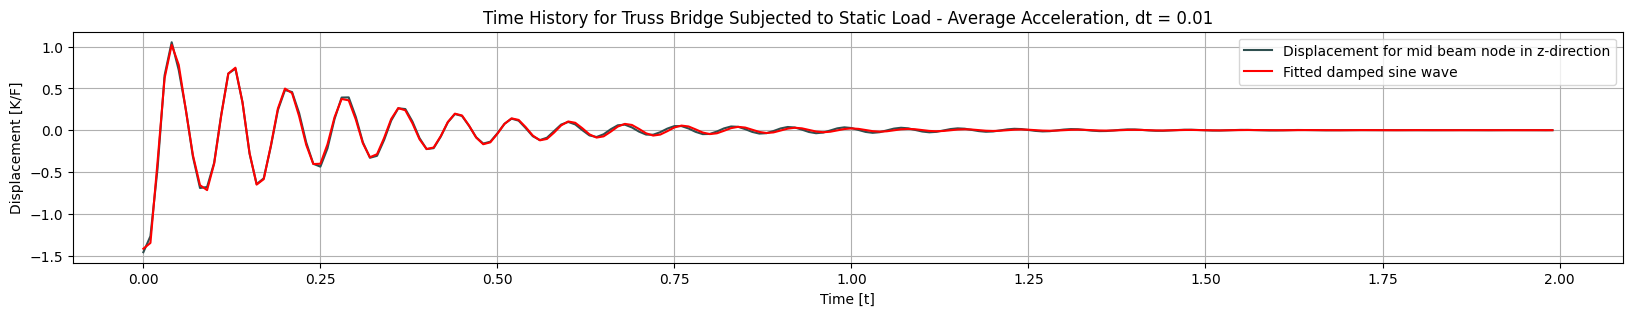

optimized parameters: 
1.2219757196303873 78.88754671432385 -2.0244226733466246 4.05947951479869 0.3606616849609378 120.84467034417685 -2.049705866477846 10.949938817640502


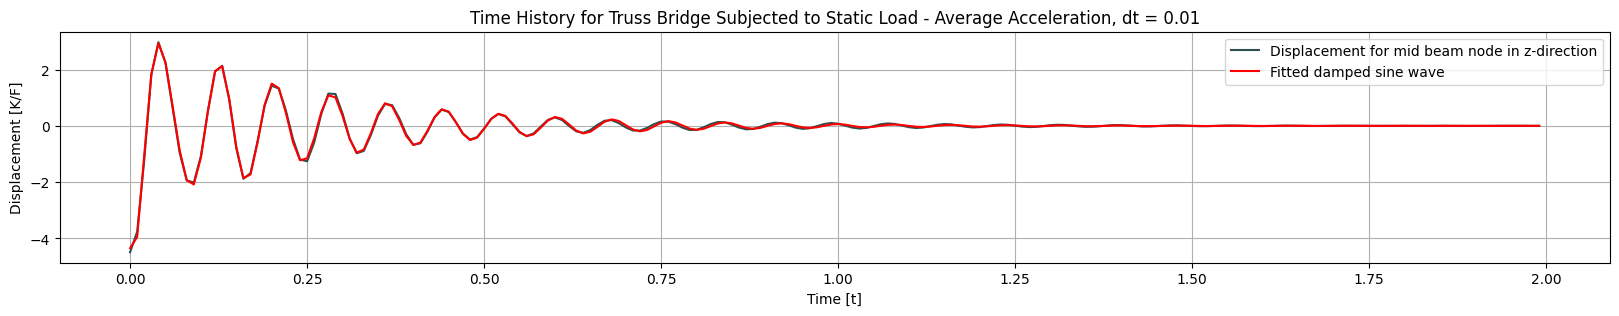

optimized parameters: 
3.5463640153513993 79.03971520716742 -2.04361081265571 4.015430345747021 1.250455004293116 118.05285063335252 -1.8891032428067371 13.656297327337189


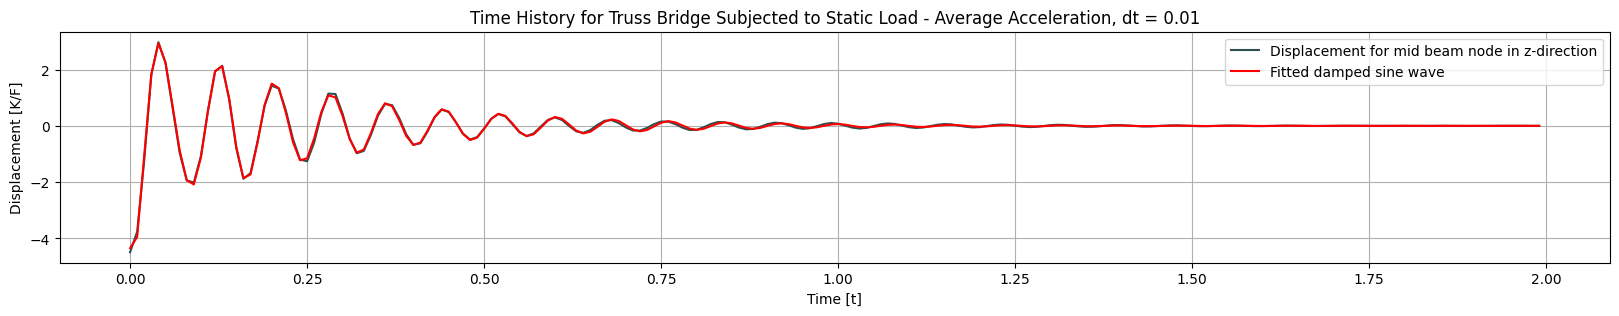

optimized parameters: 
3.5463640131392675 79.03971521328575 -2.043610814140219 4.015430342880535 1.250455011716137 118.05285053475245 -1.8891032393621952 13.656297415491567


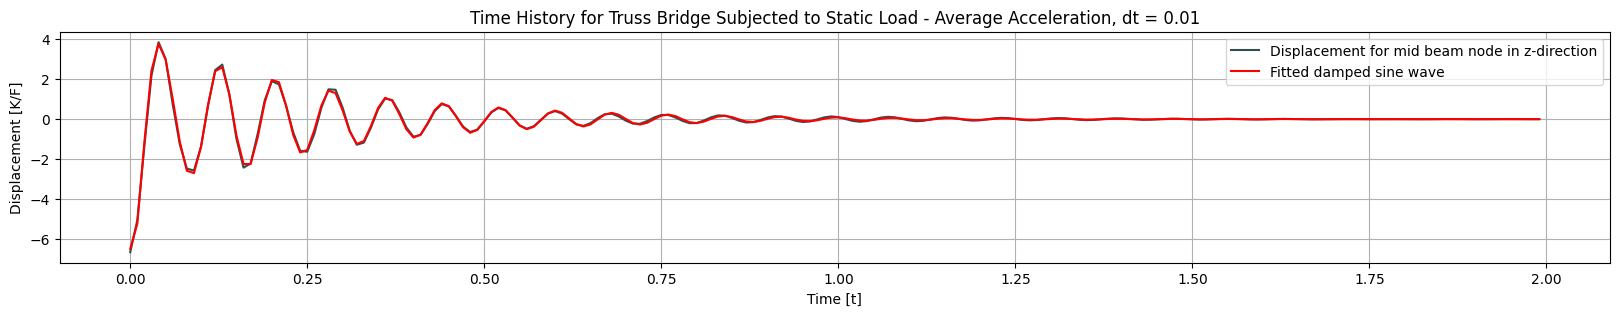

optimized parameters: 
4.564681163284029 79.27951774612318 -2.107343157914032 3.9309596201564934 2.5751395137410995 -110.03242729211644 -1.543964108516156 21.213470311538014


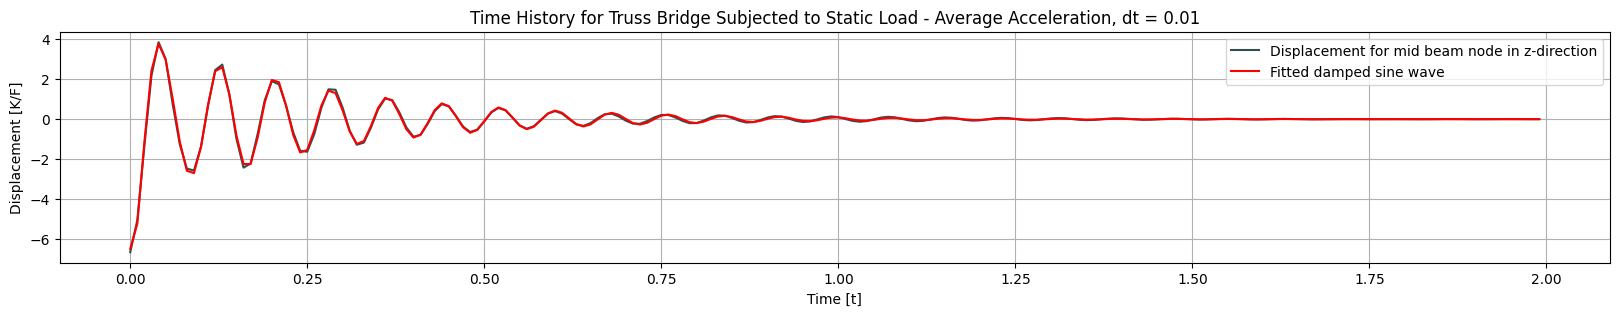

optimized parameters: 
4.564681161072312 79.27951773301352 -2.1073431544837025 3.9309596164582836 2.575139506937552 -110.03242737185981 -1.5439641059910985 21.2134703695224


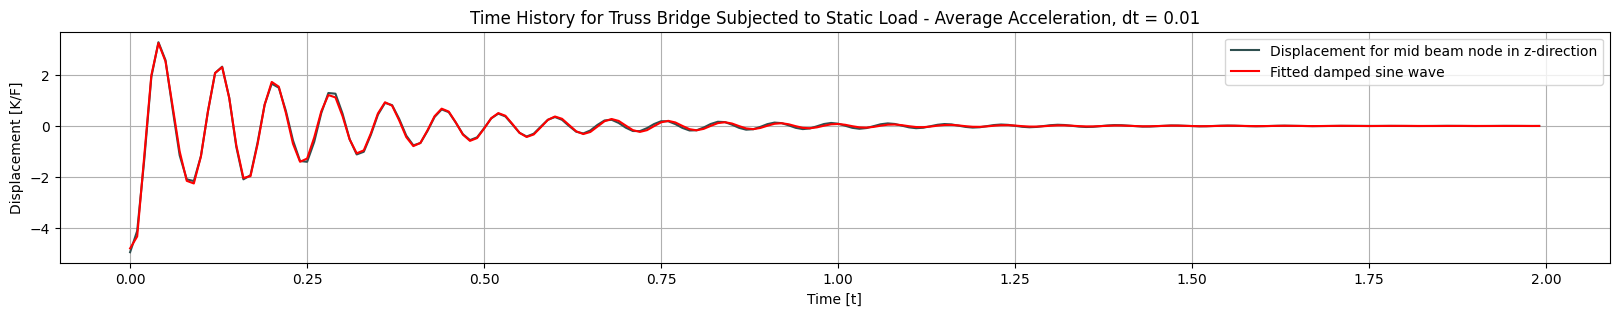

optimized parameters: 
3.9020737511782912 79.16626784488807 -2.065995004945962 3.9052045955313415 1.4218571184758064 114.8192641139774 -1.8067367663927931 13.846108477823044


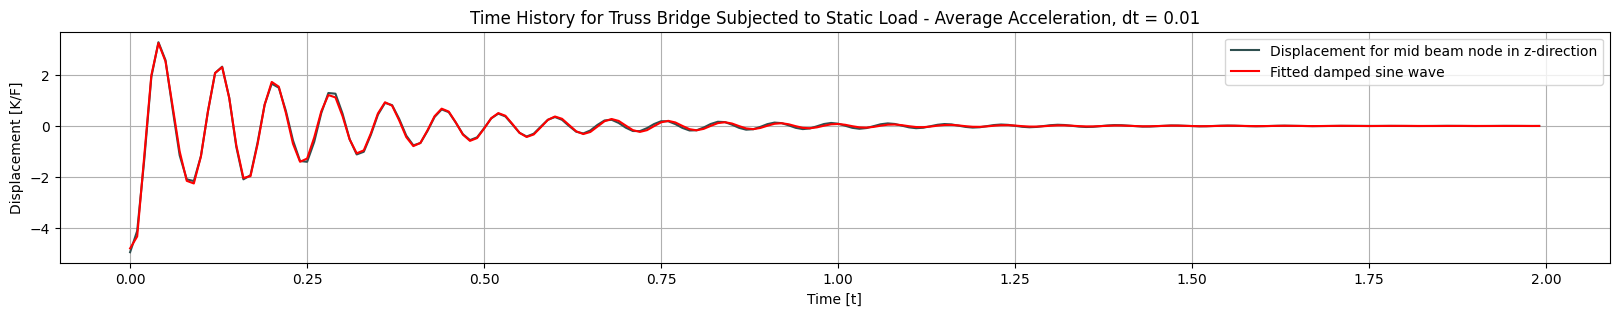

optimized parameters: 
3.9020737529824383 79.1662678410468 -2.0659950039324957 3.9052045981952808 1.4218571128687272 114.81926412566672 -1.8067367658205005 13.846108414837182


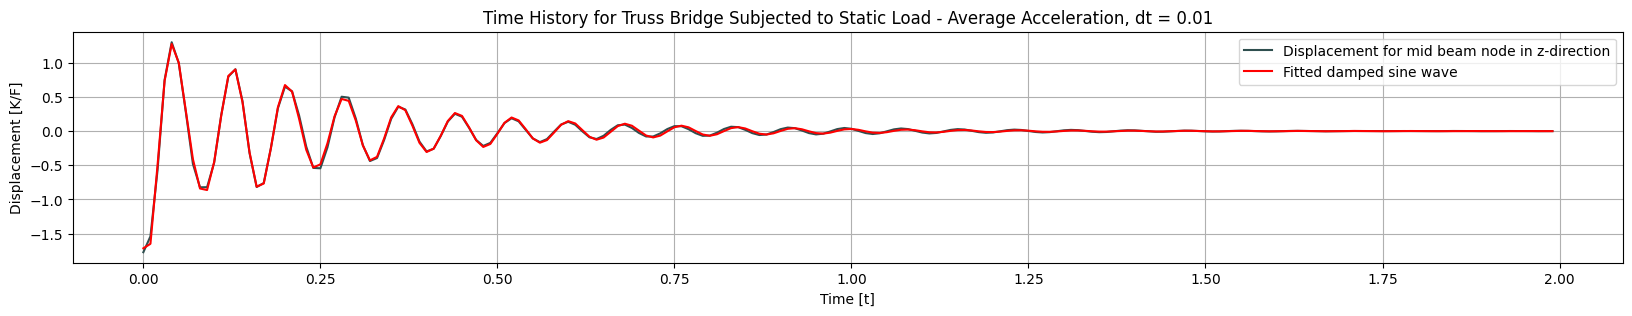

optimized parameters: 
1.4960420871414648 79.12801435295262 -2.0459820215145372 3.860761733577653 0.425022528170991 117.11921103328156 -2.0029358688958885 10.738180869121182


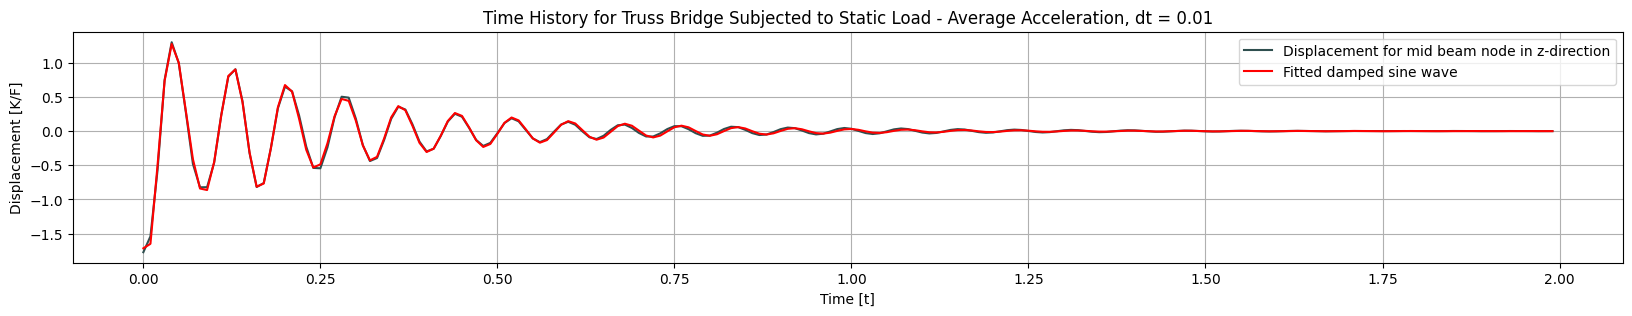

optimized parameters: 
1.4960420894962374 79.12801434093049 -2.045982018168231 3.8607617383762176 0.4250225166265078 117.11921115177383 -2.002935876198559 10.738180462443927


In [22]:
# plot for all nodes in a bridge

for i in range(data[0].shape[0]):
    fitted = damped_sine_wave_2(time, *dataY[0][i])

    title = 'Time History for Truss Bridge Subjected to Static Load - Average Acceleration, dt = '+str(dt)
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(3)
    plt.plot(time, data[0][i], color='darkslategrey', label='Displacement for mid beam node in z-direction')
    plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
    #plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
    plt.xlabel('Time [t]')
    plt.ylabel('Displacement [K/F]')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()
    print("optimized parameters: ")
    print(*dataY[0][i])

